In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [4]:
query= text("SELECT DATE(datefrom) AS date, layerid, SUM(datavalue) AS datavalue FROM movements GROUP BY date, layerid ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True) 
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

             date             layerid  datavalue
0      2019-08-01  08|033|001|000|000       3949
1      2019-08-01  08|033|002|000|000       8083
2      2019-08-01  08|033|003|000|000       2517
3      2019-08-01  08|033|004|000|000       4837
4      2019-08-01  08|033|005|000|000       2945
...           ...                 ...        ...
28323  2019-09-30  08|099|023|000|000       8008
28324  2019-09-30  08|099|024|000|000       5170
28325  2019-09-30  08|099|025|000|000      15995
28326  2019-09-30  08|099|026|000|000       3891
28327  2019-09-30  08|099|027|000|000       2501

[28328 rows x 3 columns]


In [5]:
from sklearn.preprocessing import LabelEncoder
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["weekday"] = df["date"].dt.weekday
df["week"] = df["date"].dt.isocalendar().week - df["date"].dt.isocalendar().week.min()
df['weekend'] = df['weekday'].apply(lambda w: 1  if (w == 5 or w == 6) else 0)
df["date"] = df['date'].astype('int64')
label_encoder = LabelEncoder()
df['layerid'] = label_encoder.fit_transform(df['layerid'])
df

,date,layerid,datavalue,weekday,week,weekend
0,1564617600000000000,0,3949,3,0,0
1,1564617600000000000,1,8083,3,0,0
2,1564617600000000000,2,2517,3,0,0
3,1564617600000000000,3,4837,3,0,0
4,1564617600000000000,4,2945,3,0,0
...,...,...,...,...,...,...
28323,1569801600000000000,461,8008,0,9,0
28324,1569801600000000000,462,5170,0,9,0
28325,1569801600000000000,463,15995,0,9,0
28326,1569801600000000000,464,3891,0,9,0


In [6]:
X = df.drop(['datavalue'],axis='columns')
y = df['datavalue']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Random Forest

*** Random Forest ***
MAE = 1025.8730838922227
MAPE = 11.788457246703247 %


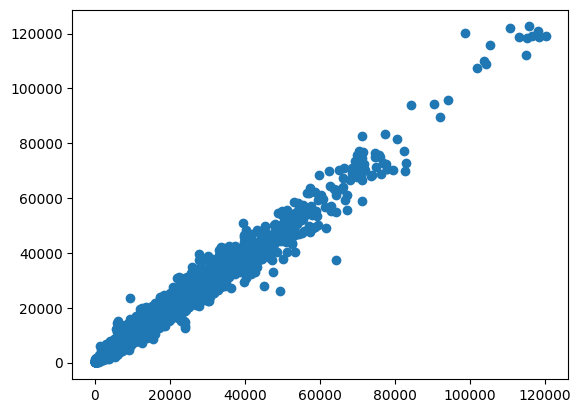

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print("*** Random Forest ***")
Model_RF = RandomForestRegressor()
Model_RF.fit(X_train, y_train)
y_pred_RF = Model_RF.predict(X_test)

print('MAE =', mean_absolute_error(y_test, y_pred_RF))
print('MAPE =', mean_absolute_percentage_error(y_test, y_pred_RF)*100 ,'%')
MAPE_RF = mean_absolute_percentage_error(y_test, y_pred_RF)*100
plt.scatter(y_test, y_pred_RF)
plt.show()

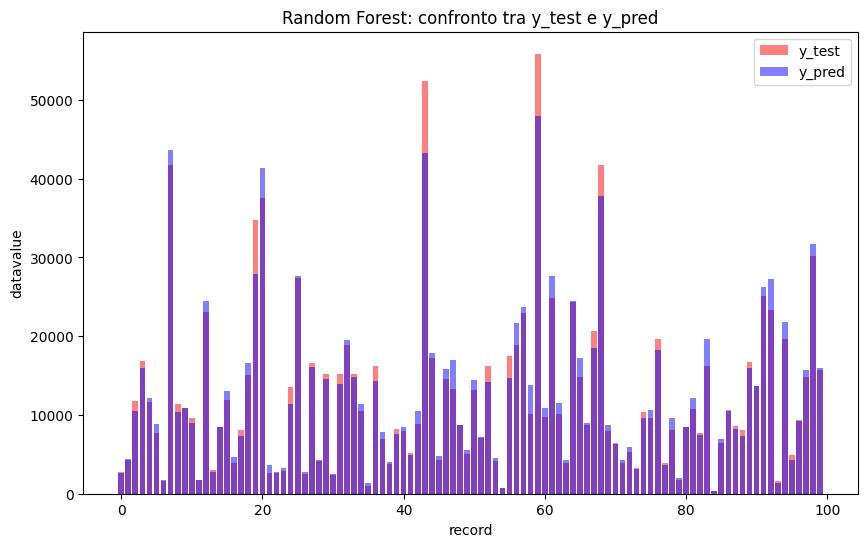

In [10]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_RF[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('Random Forest: confronto tra y_test e y_pred')
plt.legend()
plt.show()

K-Nearest Neighbors

In [12]:
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor

k = 5

In [14]:
selector1 = SelectKBest(score_func=f_regression, k=5)
X_train_selected1 = selector1.fit_transform(X_train, y_train)
X_test_selected1 = selector1.transform(X_test)

y_train_scaled_KNN1 = np.log1p(y_train)
y_test_scaled_KNN1 = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_KNN1 = scaler.fit_transform(X_train_selected1)
X_test_scaled_KNN1 = scaler.transform(X_test_selected1)

param_grid = {
    'n_neighbors': range(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train_scaled_KNN1, y_train_scaled_KNN1)
selected_features = X_train.columns[selector1.get_support()]
print("Feature selezionate:", selected_features.tolist())
best_params = grid_search.best_params_
print("Migliori parametri:", best_params)

Feature selezionate: ['date', 'layerid', 'weekday', 'week', 'weekend']
Migliori parametri: {'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'}


*** K-Nearest Neighbors ***
MAE = 6528.765406910852
MAPE = 136.50178023168309 %


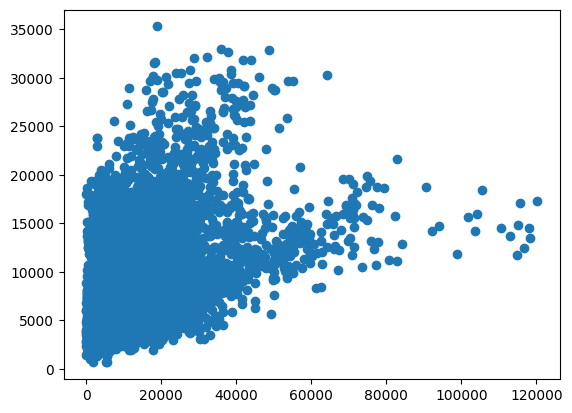

In [15]:
print("*** K-Nearest Neighbors ***")
Model_KNN1 = KNeighborsRegressor(
    n_neighbors= best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)

Model_KNN1.fit(X_train_scaled_KNN1, y_train_scaled_KNN1)
y_pred_KNN1 = Model_KNN1.predict(X_test_scaled_KNN1)

y_pred_KNN1 = np.expm1(y_pred_KNN1)
y_test = np.expm1(y_test_scaled_KNN1)

print('MAE =', mean_absolute_error(y_test, y_pred_KNN1))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_KNN1)*100,'%')
plt.scatter(y_test, y_pred_KNN1)
plt.show()

k = 2

In [17]:
selector = SelectKBest(score_func=f_regression, k=2)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

y_train_scaled_KNN = np.log1p(y_train)
y_test_scaled_KNN = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_KNN = scaler.fit_transform(X_train_selected)
X_test_scaled_KNN = scaler.transform(X_test_selected)

param_grid = {
    'n_neighbors': range(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train_scaled_KNN, y_train_scaled_KNN)
selected_features = X_train.columns[selector.get_support()]
print("Feature selezionate:", selected_features.tolist())
best_params = grid_search.best_params_
print("Migliori parametri:", best_params)

Feature selezionate: ['layerid', 'week']
Migliori parametri: {'metric': 'euclidean', 'n_neighbors': 49, 'weights': 'distance'}


*** K-Nearest Neighbors ***
MAE = 1657.7722970429313
MAPE = 21.216899912062072 %


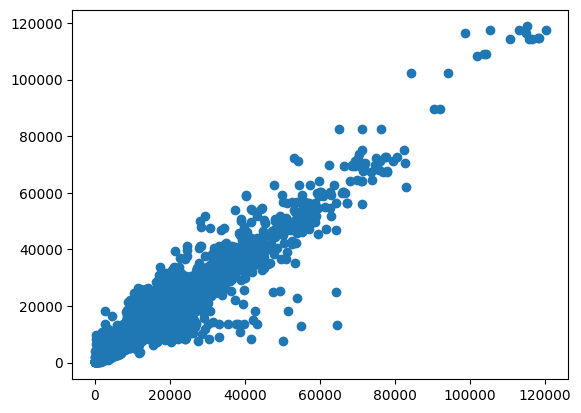

In [18]:
print("*** K-Nearest Neighbors ***")
Model_KNN = KNeighborsRegressor(
    n_neighbors= best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)

Model_KNN.fit(X_train_scaled_KNN, y_train_scaled_KNN)
y_pred_KNN = Model_KNN.predict(X_test_scaled_KNN)

y_pred_KNN = np.expm1(y_pred_KNN)
y_test = np.expm1(y_test_scaled_KNN)

print('MAE =', mean_absolute_error(y_test, y_pred_KNN))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_KNN)*100,'%')
MAPE_KNN = mean_absolute_percentage_error(y_test, y_pred_KNN)*100
plt.scatter(y_test, y_pred_KNN)
plt.show()

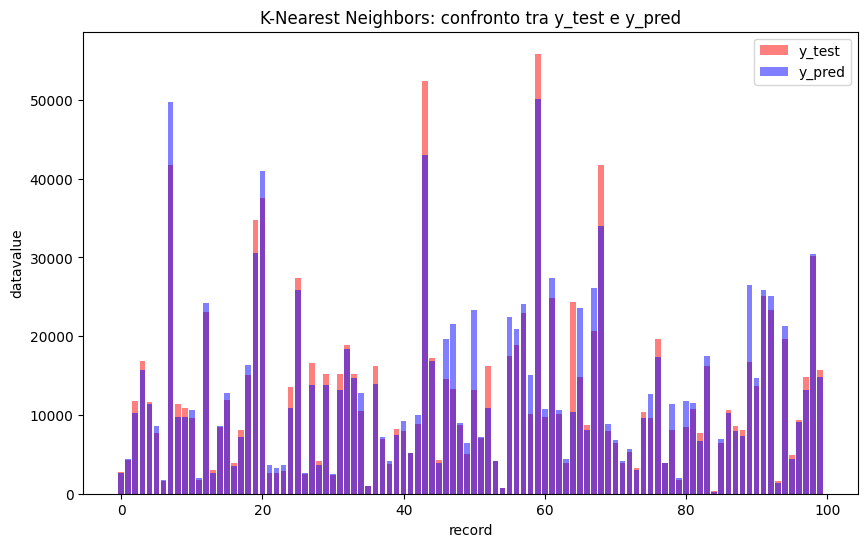

In [19]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_KNN[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('K-Nearest Neighbors: confronto tra y_test e y_pred')
plt.legend()
plt.show()

Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

y_train_scaled_GB = np.log1p(y_train)
y_test_scaled_GB = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_GB = scaler.fit_transform(X_train)
X_test_scaled_GB = scaler.transform(X_test)

Model_GB = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7]  
}

grid_search = GridSearchCV(estimator=Model_GB, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_GB, y_train_scaled_GB)
print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori parametri trovati: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}


*** Gradient Boosting ***
MAE = 1004.2504683589932
MAPE = 10.91513551863344 %


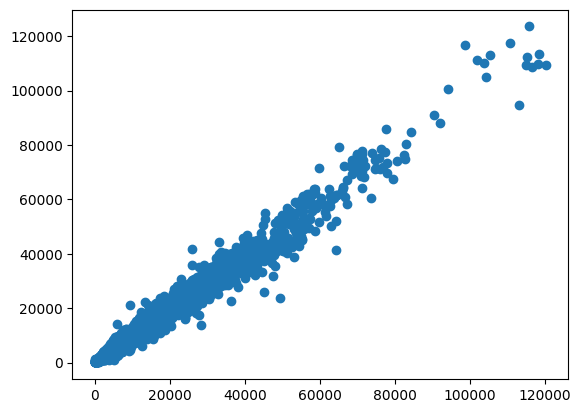

In [22]:
print("*** Gradient Boosting ***")
best_model = grid_search.best_estimator_
y_pred_GB = best_model.predict(X_test_scaled_GB)

y_pred_GB =np.expm1(y_pred_GB)
y_test =np.expm1(y_test_scaled_GB)
print('MAE =', mean_absolute_error(y_test, y_pred_GB))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_GB)*100,'%')
MAPE_GB = mean_absolute_percentage_error(y_test, y_pred_GB)*100
plt.scatter(y_test, y_pred_GB)
plt.show()

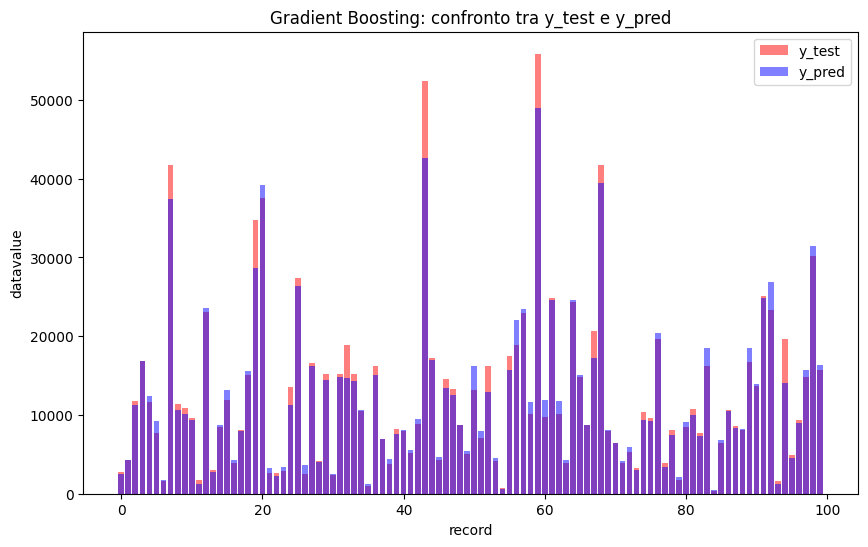

In [23]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_GB[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('Gradient Boosting: confronto tra y_test e y_pred')
plt.legend()
plt.show()

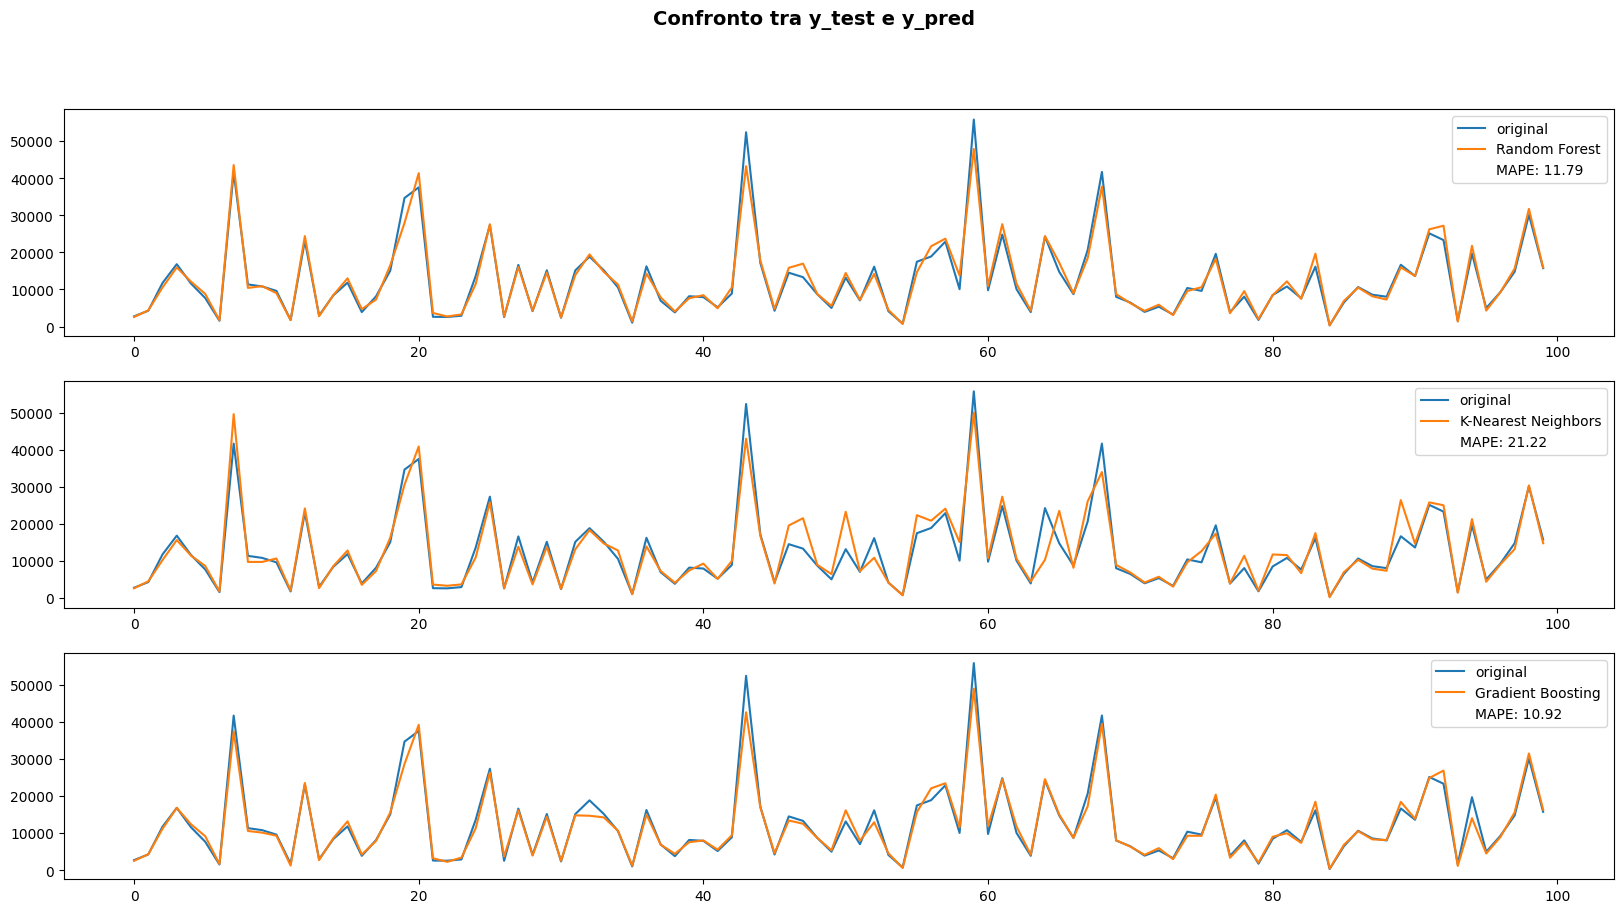

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10)) 
fig.suptitle('Confronto tra y_test e y_pred', fontsize=14, fontweight='bold')
axes[0].plot(indici, y_test[:100], label='original')
axes[0].plot(indici, y_pred_RF[:100],label='Random Forest')
axes[0].legend()
axes[0].plot([], [], ' ', label=f'MAPE: {MAPE_RF:.2f}')
axes[0].legend()
axes[1].plot(indici, y_test[:100], label='original')
axes[1].plot(indici, y_pred_KNN[:100],label='K-Nearest Neighbors')
axes[1].plot([], [], ' ', label=f'MAPE: {MAPE_KNN:.2f}')
axes[1].legend()
axes[2].plot(indici, y_test[:100], label='original')
axes[2].plot(indici, y_pred_GB[:100],label='Gradient Boosting')
axes[2].plot([], [], ' ', label=f'MAPE: {MAPE_GB:.2f}')
axes[2].legend()
plt.show()